In [4]:
#!pip install lingam
#!pip install econml

# Data is taken from Kaggle insurance dataset: https://www.kaggle.com/code/prathamkyada/insurance-premium-prediction/input?select=insurance.csv

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

#LiNGAM algorithm for causal discovery
from lingam import DirectLiNGAM
from lingam.utils import make_dot

# EconML and sklearn pacakges for heterogeneous treatment effect estimation
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV

# Show all columns regardless of how many there are
pd.set_option('display.max_columns', None)
# Increase the width of the display area
pd.set_option('display.width', 2000)
# Optional: suppress scientific notation for clearer causal weights
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def display_df(df):
  styled_df = df.style.format("{:.3f}").set_table_styles([
    {'selector': 'th', 'props': [('white-space', 'nowrap')]},
    {'selector': 'td', 'props': [('white-space', 'nowrap')]}
  ])

  display(styled_df)


data_df = pd.read_csv('insurance.csv')
data_df.head(1)
print(data_df.describe())
print(data_df.info())
numeric_cols = data_df.select_dtypes(exclude='object').columns.tolist()
print(numeric_cols)


            age       bmi  children   expenses
count 1338.0000 1338.0000 1338.0000  1338.0000
mean    39.2070   30.6655    1.0949 13270.4224
std     14.0500    6.0984    1.2055 12110.0112
min     18.0000   16.0000    0.0000  1121.8700
25%     27.0000   26.3000    0.0000  4740.2875
50%     39.0000   30.4000    1.0000  9382.0300
75%     51.0000   34.7000    2.0000 16639.9150
max     64.0000   53.1000    5.0000 63770.4300
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
['age', 'bmi', 'children', 'expenses']


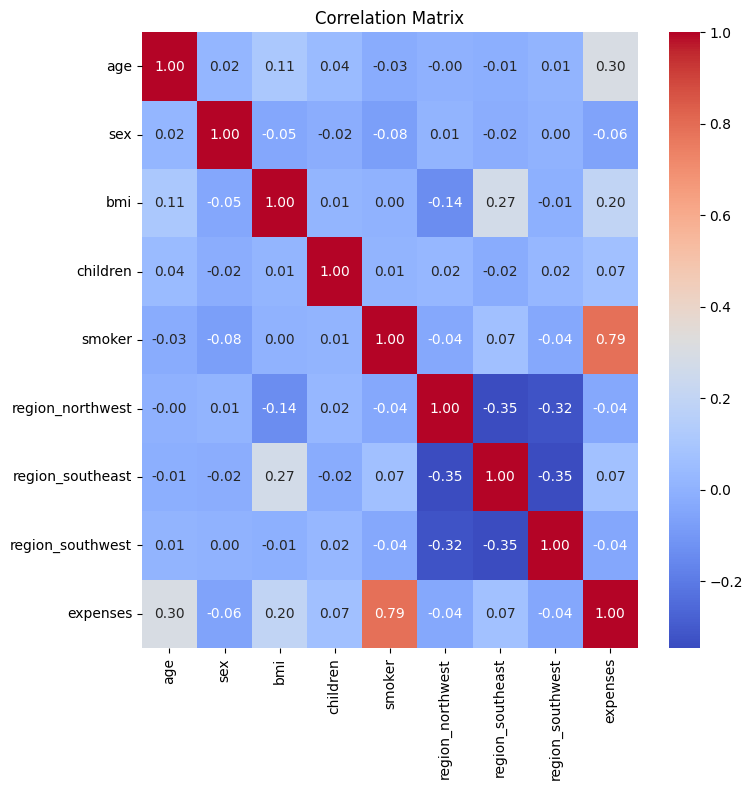

Estimated causal order:
region_southwest
age
region_northwest
region_southeast
sex
children
bmi
smoker
expenses


,age,sex,bmi,children,smoker,expenses,region_northwest,region_southeast,region_southwest
age,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
sex,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
bmi,0.112,0.000,0.000,0.000,0.000,0.000,0.000,0.305,0.098
children,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
smoker,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
expenses,0.299,0.000,0.162,0.047,0.794,0.000,0.000,0.000,0.000
region_northwest,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
region_southeast,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
region_southwest,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


digraph {
	age
	sex
	bmi
	children
	smoker
	expenses
	region_northwest
	region_southeast
	region_southwest
	age -> bmi [label=0.11]
	region_southeast -> bmi [label=0.31]
	region_southwest -> bmi [label=0.10]
	age -> expenses [label=0.30]
	bmi -> expenses [label=0.16]
	children -> expenses [label=0.05]
	smoker -> expenses [label=0.79]
	{
		rank=same
	}
}



In [6]:
############################################################################################################################################
# Apply LiNGAM algorithm for causal discovery. Business rules can be applied to prevent causal hypotheses that do not seem feasible
# Get the adjacency matrix. The values in the LiNGAM adjacency matrix represent the path coefficients (or causal weights),
# which quantify the strength of the linear relationship between the cause and the effect.
############################################################################################################################################


df = data_df.copy()
target_var = "expenses"
add_business_rules = True # Add rules for removing hypotheses which seem implausible, for example smoker->sex/gender

############################################################################################################################################
# Data pre-processing

# Ensure binary variables are numeric
df['sex'] = df['sex'].map({'male':0, 'female':1})
df['smoker'] = df['smoker'].map({'no':0, 'yes':1})
df = pd.get_dummies(df, columns=['region'], drop_first=True)
df = df.astype(float)
col_names = df.columns.tolist()

# Plot using seaborn
plt.figure(figsize=(8,8))
cols_not_target = [col for col in df.columns if col != target_var]

sns.heatmap(df[cols_not_target+[target_var]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Standardize (important for LiNGAM)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)


############################################################################################################################################
# Apply business rules
# Initialize a matrix of -1 (meaning business rules are not defined yet)
pk = np.full((len(col_names), len(col_names)), -1)

# Get indices for easier mapping
idx = {name: i for i, name in enumerate(col_names)}

# RULE 1: Nothing can cause Age, Sex, or Region (they are exogenous)
if add_business_rules:
  for target in ['age', 'sex', 'region_southwest', 'region_southeast', 'region_northwest', 'region_northeast']:
      if target in idx:
          pk[idx[target], :] = 0  # Set the entire row to 0 (nothing points TO these)



# RULE 2: Expenses cannot cause anything (it is the target feature)
if target_var in idx:
    pk[:, idx[target_var]] = 0  # Set the entire column to 0 (expenses points to NOTHING)


############################################################################################################################################
# Re-run LiNGAM with prior knowledge
lingam_model = DirectLiNGAM(prior_knowledge=pk)

#lingam_model = DirectLiNGAM()
lingam_model.fit(X_scaled)

# Causal ordering
# Estimated Causal Order represents the sequence in which variables are determined. Because LiNGAM assumes a Directed Acyclic Graph (DAG),
# there must be an order where no variable can cause one that comes before it in the list.
# The Causal Flow: A variable at position n in the list can only be caused by variables at positions 1 through n-1.
# For example, since smoker is 8th and expenses is 9th, LiNGAM model allows smoker to cause expenses, but it strictly forbids expenses from causing smoker.
causal_order = lingam_model.causal_order_
print("Estimated causal order:")
for i in causal_order:
    print(col_names[i])

assert col_names[causal_order[-1]] == target_var, f"The last feature in the causal order is not the target feature {target_var}"

# Adjacency matrix
adjacency_matrix = pd.DataFrame(
    lingam_model.adjacency_matrix_,
    index=col_names,
    columns=col_names
)

# Format to 3 decimal places and prevent wrapping
display_df(adjacency_matrix)

############################################################################################################################################
# Check the causal hypotheses from the adjacency matrix before plotting

dot = make_dot(
    lingam_model.adjacency_matrix_,
    labels=col_names
)
print(dot)


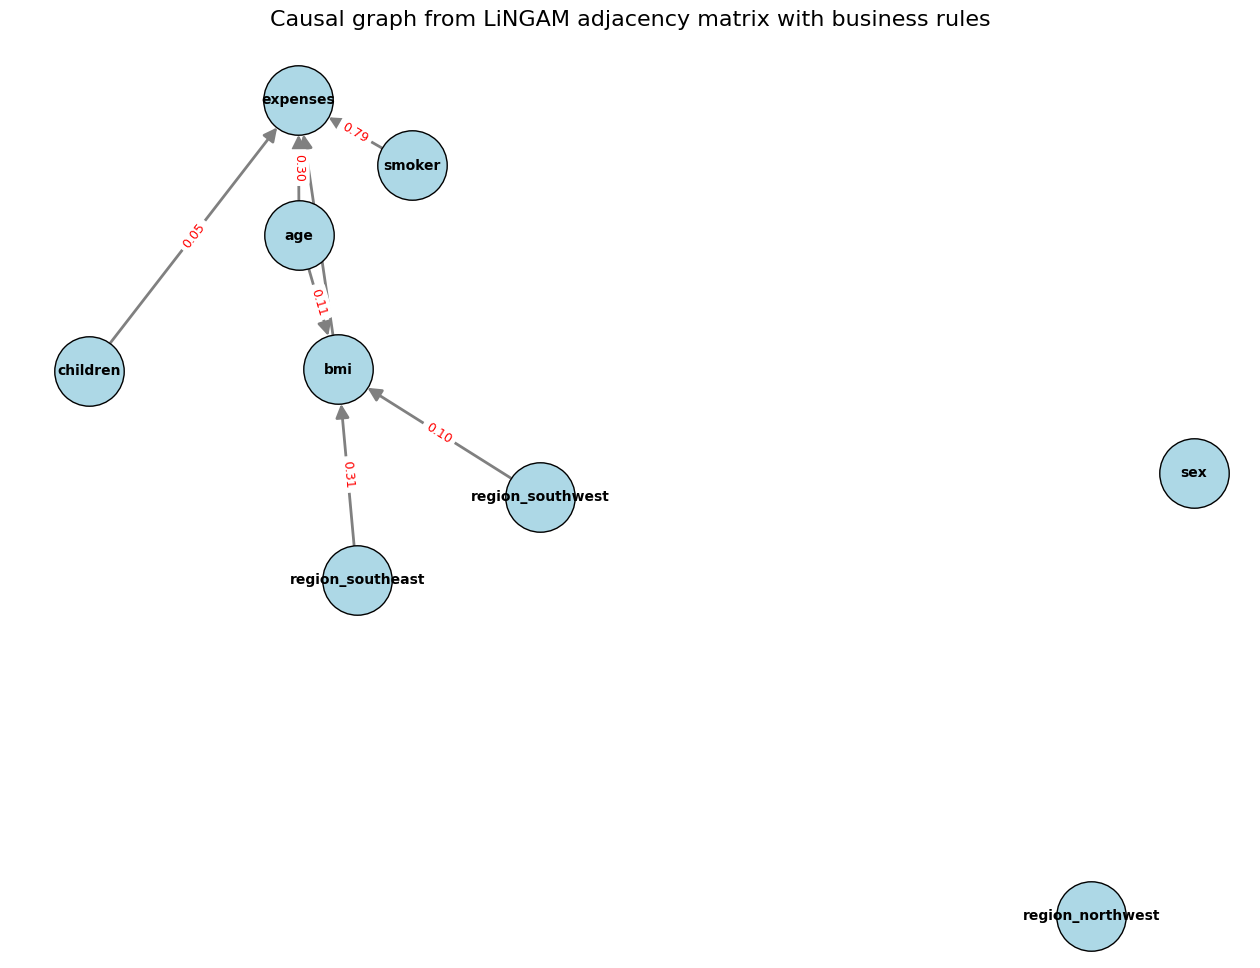

In [7]:

############################################################################################################################################
# Draw the directed causal graph from the adjacency matrix
############################################################################################################################################

# 1.Create directed graph

'''
In a LiNGAM adjacency matrix, the cause appears in the column and the effect appears in the row.
So if you have adjacency_matrix[i, j] (or adjacency_matrix.loc[row_i, col_j]):

A non-zero value means: col_j → row_i (column causes row)
The value represents the strength/coefficient of the causal effect

This follows the structural equation model (SEM) convention where:

Each row represents an equation for that variable
Non-zero entries in that row show which variables (columns) causally influence it
'''
G = nx.DiGraph()
G.add_nodes_from(col_names)

# In LiNGAM matrix B_ij: j is the cause (column), i is the effect (row)
for i, target in enumerate(col_names):     # i = Row index
    for j, source in enumerate(col_names): # j = Column index
        weight = adjacency_matrix.iloc[i, j]
        if weight != 0:
            # Arrow goes from column variable to row variable
            G.add_edge(source, target, weight=weight)

# 2.Extract edge labels (formatted)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

# 3.Layout
try:
    # Graphviz 'dot' layout (hierarchical) if pygraphviz is installed
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
except:
    # Fallback to spring layout
    pos = nx.spring_layout(G, seed=42)

# 4.Draw nodes
plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color="lightblue", edgecolors="black")

# 5.Draw edges
# nx.draw_networkx_edges(G, pos, arrowsize=20, edge_color="gray", width=2)
# Draw edges with arrows (Fixed)
nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle="-|>",
    arrowsize=20,
    edge_color="gray",
    width=2,
    # This tells NetworkX where to stop the arrow so it's not hidden
    node_size=2500,
    # Optional: adds a small gap between the arrow tip and the node
    min_target_margin=20
)

# 6.Draw node labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# 7.Draw edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=9)

if add_business_rules:
    plt.title("Causal graph from LiNGAM adjacency matrix with business rules", fontsize=16)
else:
  plt.title("Causal graph from LiNGAM adjacency matrix with no business rules", fontsize=16)
plt.axis("off")
plt.show()


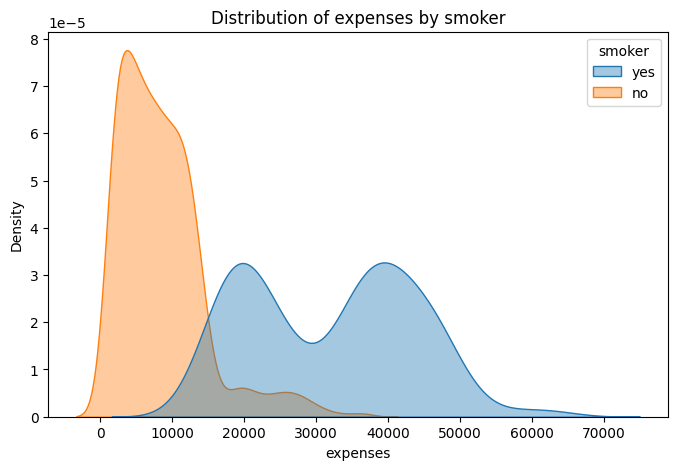

In [8]:
############################################################################################################################################
# Draw the Kernel density estimate (KDE) plot to check the distribution of a causal feature vs target. Helps in sanity check for
# treatment effect calculated using EconML.
############################################################################################################################################
treatment_var = "smoker"

plt.figure(figsize=(8, 5))

sns.kdeplot(
    data=data_df,
    x=target_var,
    hue=treatment_var,
    fill=True,
    common_norm=False,
    alpha=0.4
)

plt.title(f"Distribution of {target_var} by {treatment_var}")
plt.xlabel(target_var)
plt.ylabel("Density")
plt.show()


In [10]:

############################################################################################################################################
# Heterogeneous treatment effect estimation
############################################################################################################################################

T = df[treatment_var].values
Y = df[target_var].values

print(T)
confounders = [col for col in df.columns if col not in [treatment_var, target_var]]
print("confounders: ", confounders)

X = df[confounders].values


dml = LinearDML(
    model_y=RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=10,
        random_state=42
    ),
    model_t = RandomForestClassifier(
        n_estimators=200,
        min_samples_leaf=10,
        random_state=42
    ),
    discrete_treatment=True,
    random_state=42
)

dml.fit(Y, T, X=X)

cate = dml.effect(X)

df_cate = df.copy()
df_cate[f"CATE_{treatment_var}"] = cate

display_df(df_cate.head(5))


[1. 0. 0. ... 0. 0. 1.]
confounders:  ['age', 'sex', 'bmi', 'children', 'region_northwest', 'region_southeast', 'region_southwest']


,age,sex,bmi,children,smoker,expenses,region_northwest,region_southeast,region_southwest,CATE_smoker
0,19.000,1.000,27.900,0.000,1.000,16884.920,0.000,0.000,1.000,21436.281
1,18.000,0.000,33.800,1.000,0.000,1725.550,0.000,1.000,0.000,27737.582
2,28.000,0.000,33.000,3.000,0.000,4449.460,0.000,1.000,0.000,26129.647
3,33.000,0.000,22.700,0.000,0.000,21984.470,1.000,0.000,0.000,12210.566
4,32.000,0.000,28.900,0.000,0.000,3866.860,1.000,0.000,0.000,21436.998


In [11]:

############################################################################################################################################
# Heterogeneous treatment effect estimation
############################################################################################################################################

treatment_var = "age"
T = df[treatment_var].values
Y = df[target_var].values

print(T)
confounders = [col for col in df.columns if col not in [treatment_var, target_var]]
print("confounders: ", confounders)

X = df[confounders].values


dml = LinearDML(
    model_y=RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=10,
        random_state=42
    ),
    model_t = RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=10,
        random_state=42
    ),
    discrete_treatment=False,
    random_state=42
)

dml.fit(Y, T, X=X)

cate = dml.effect(X)

df_cate = df.copy()
df_cate[f"CATE_{treatment_var}"] = cate

display_df(df_cate.head(5))


[19. 18. 28. ... 18. 21. 61.]
confounders:  ['sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']


,age,sex,bmi,children,smoker,expenses,region_northwest,region_southeast,region_southwest,CATE_age
0,19.000,1.000,27.900,0.000,1.000,16884.920,0.000,0.000,1.000,269.132
1,18.000,0.000,33.800,1.000,0.000,1725.550,0.000,1.000,0.000,288.042
2,28.000,0.000,33.000,3.000,0.000,4449.460,0.000,1.000,0.000,277.251
3,33.000,0.000,22.700,0.000,0.000,21984.470,1.000,0.000,0.000,263.525
4,32.000,0.000,28.900,0.000,0.000,3866.860,1.000,0.000,0.000,261.046
